NOTEBOOK - LIMPIO

1 - IMPORTAMOS LIBRERIAS Y LEEMOS LOS DATOS

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pl.offline.init_notebook_mode(connected=True)
data= "../../Data/properatti.csv"
propiedades= pd.read_csv(data)

COMENZAMOS CON LA LIMPIEZA DE DATOS


In [2]:
#creamos un dataframe nuevo tomando en cuenta solo las propiedades de Capital Federal
propiedades_capital=propiedades.loc[(propiedades.state_name=="Capital Federal")]
propiedades_capital.state_name.value_counts()

Capital Federal    32316
Name: state_name, dtype: int64

In [3]:
#creamos una serie dummy para saber el tipo de cambio utilizado a la fecha del registro
#SOLO DE MANERA INFORMATIVA
dummy=propiedades_capital['price_aprox_local_currency']/propiedades_capital['price_aprox_usd']
tasa_cambio=dummy.mean()
tasa_cambio

17.644499993856833

In [4]:
#chequeamos la cantidad de valores faltantes en la columna price_usd_per_m2
#nos interesa ese campo ya que el precio en moneda local está sujeto a una tasa de cambio muy volatil 
#o inestables en el tiempo (tenemos la tasa de cambio a la fecha que se creo el DF pero no cuando se grabaron los datos 
#de cada propiedad), en este caso nos guiaremos por el valor en USD$ y el area o superficie de la propiedad
propiedades_capital.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
dtype: int64

In [5]:
#Columnas con pocos valores
i=0
for label, content in propiedades_capital.iteritems():
    num=len(pd.unique(propiedades_capital.iloc[:,i]))
    porcentaje=float(num)/propiedades_capital.shape[0]*100
    print("%s, %d, %.1f%%"%(label,num,porcentaje))
    propiedades_capital.iteritems()
    i=i+1


Unnamed: 0, 32316, 100.0%
operation, 1, 0.0%
property_type, 4, 0.0%
place_name, 62, 0.2%
place_with_parent_names, 62, 0.2%
country_name, 1, 0.0%
state_name, 1, 0.0%
geonames_id, 53, 0.2%
lat-lon, 14161, 43.8%
lat, 13885, 43.0%
lon, 13900, 43.0%
price, 5205, 16.1%
currency, 4, 0.0%
price_aprox_local_currency, 5295, 16.4%
price_aprox_usd, 5295, 16.4%
surface_total_in_m2, 751, 2.3%
surface_covered_in_m2, 618, 1.9%
price_usd_per_m2, 10877, 33.7%
price_per_m2, 11747, 36.4%
floor, 86, 0.3%
rooms, 19, 0.1%
expenses, 755, 2.3%
properati_url, 32316, 100.0%
description, 26094, 80.7%
title, 18144, 56.1%
image_thumbnail, 30255, 93.6%


In [6]:
#Observamos si hay filas duplicadas y de ser asi las eliminamos
duplicado = propiedades_capital.duplicated()
print(duplicado.any())
print(propiedades_capital[duplicado])
print(propiedades.shape)
propiedades.drop_duplicates(inplace=True)
print(propiedades.shape)

False
Empty DataFrame
Columns: [Unnamed: 0, operation, property_type, place_name, place_with_parent_names, country_name, state_name, geonames_id, lat-lon, lat, lon, price, currency, price_aprox_local_currency, price_aprox_usd, surface_total_in_m2, surface_covered_in_m2, price_usd_per_m2, price_per_m2, floor, rooms, expenses, properati_url, description, title, image_thumbnail]
Index: []

[0 rows x 26 columns]
(121220, 26)
(121220, 26)


In [7]:
#creamos una serie nueva tomando el promedio del m2 en dolares con respecto al barrio (lo usaremos posteriormente para llenas los NaN)

pricem2USD_fill_values=propiedades_capital.groupby('place_name').price_usd_per_m2.mean()
pricem2USD_fill_values

place_name
Abasto              2057.529147
Agronomía           2088.124134
Almagro             2749.102521
Balvanera           1982.249390
Barracas            1969.946866
                       ...     
Villa Riachuelo     1110.690766
Villa Santa Rita    1889.186620
Villa Soldati        743.666758
Villa Urquiza       2495.288265
Villa del Parque    2233.837905
Name: price_usd_per_m2, Length: 62, dtype: float64

In [8]:
#creamos un dataFrame nuevo con los valores de la serie obtenida anteriormente y hacemos un merge a propiedades_capital2 en una nueva columna 
#con el promedio del m2 en dolares

pricem2USD_fill_values_df= pd.DataFrame(pricem2USD_fill_values)
pricem2USD_fill_values_df.reset_index(inplace=True)
propiedades_capital2=propiedades_capital.merge(pricem2USD_fill_values_df, on= 'place_name', how='left', suffixes = ("", "_mean"))

#usamos fillna para substituir los NaN con los valores en la columna price_usd_per_m2_mean
propiedades_capital2.price_usd_per_m2.fillna(propiedades_capital2.price_usd_per_m2_mean, inplace = True)

In [9]:
#chequeamos que no existan NaN en price_usd_per_m2
propiedades_capital2.price_usd_per_m2.isna().sum()

0

In [10]:
#hacemos un describe la columna price_usd_per_m2
propiedades_capital2.price_usd_per_m2.describe()

count     32316.000000
mean       3040.608512
std        3230.037746
min          13.797467
25%        2000.000000
50%        2495.288265
75%        3153.981976
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [11]:
#removemos los outliers de ese campo
removed_outliers = propiedades_capital2.price_usd_per_m2.between(propiedades_capital2.price_usd_per_m2.quantile(.05), propiedades_capital2.price_usd_per_m2.quantile(.95))

<AxesSubplot:xlabel='Barrios'>

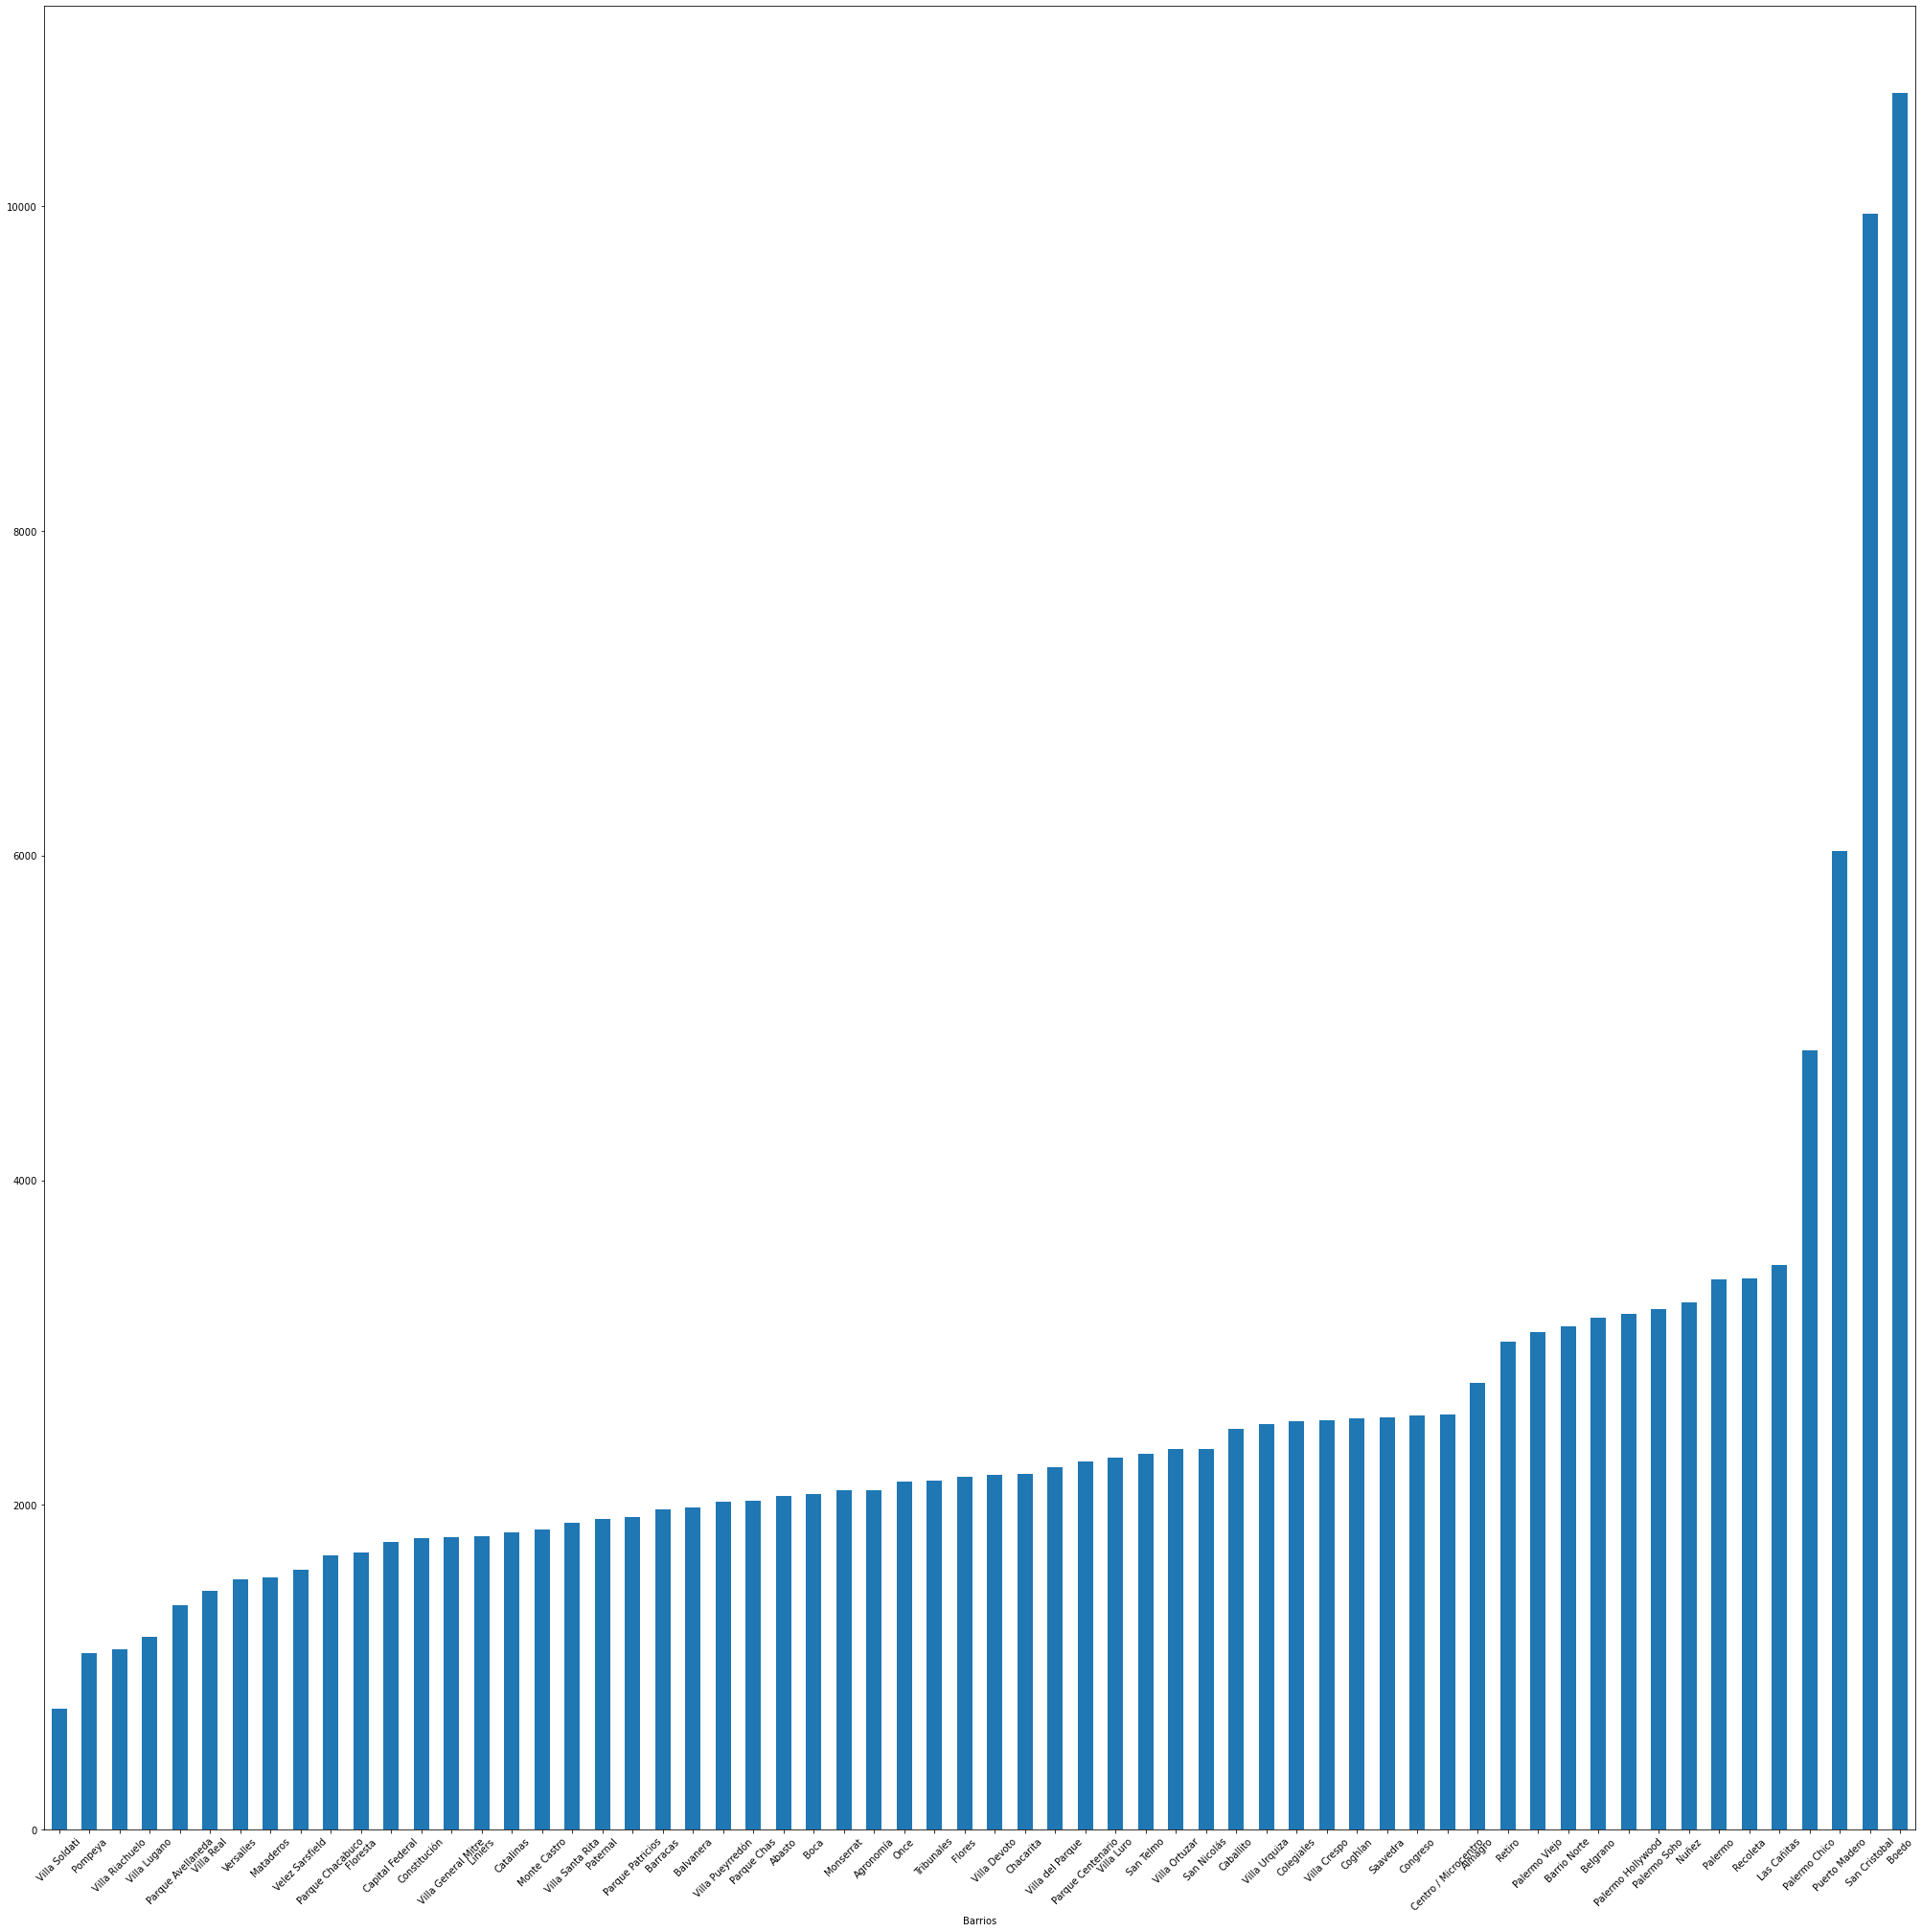

In [12]:
#graficamos el dataframe sin limpiar
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2.groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

<AxesSubplot:xlabel='Barrios'>

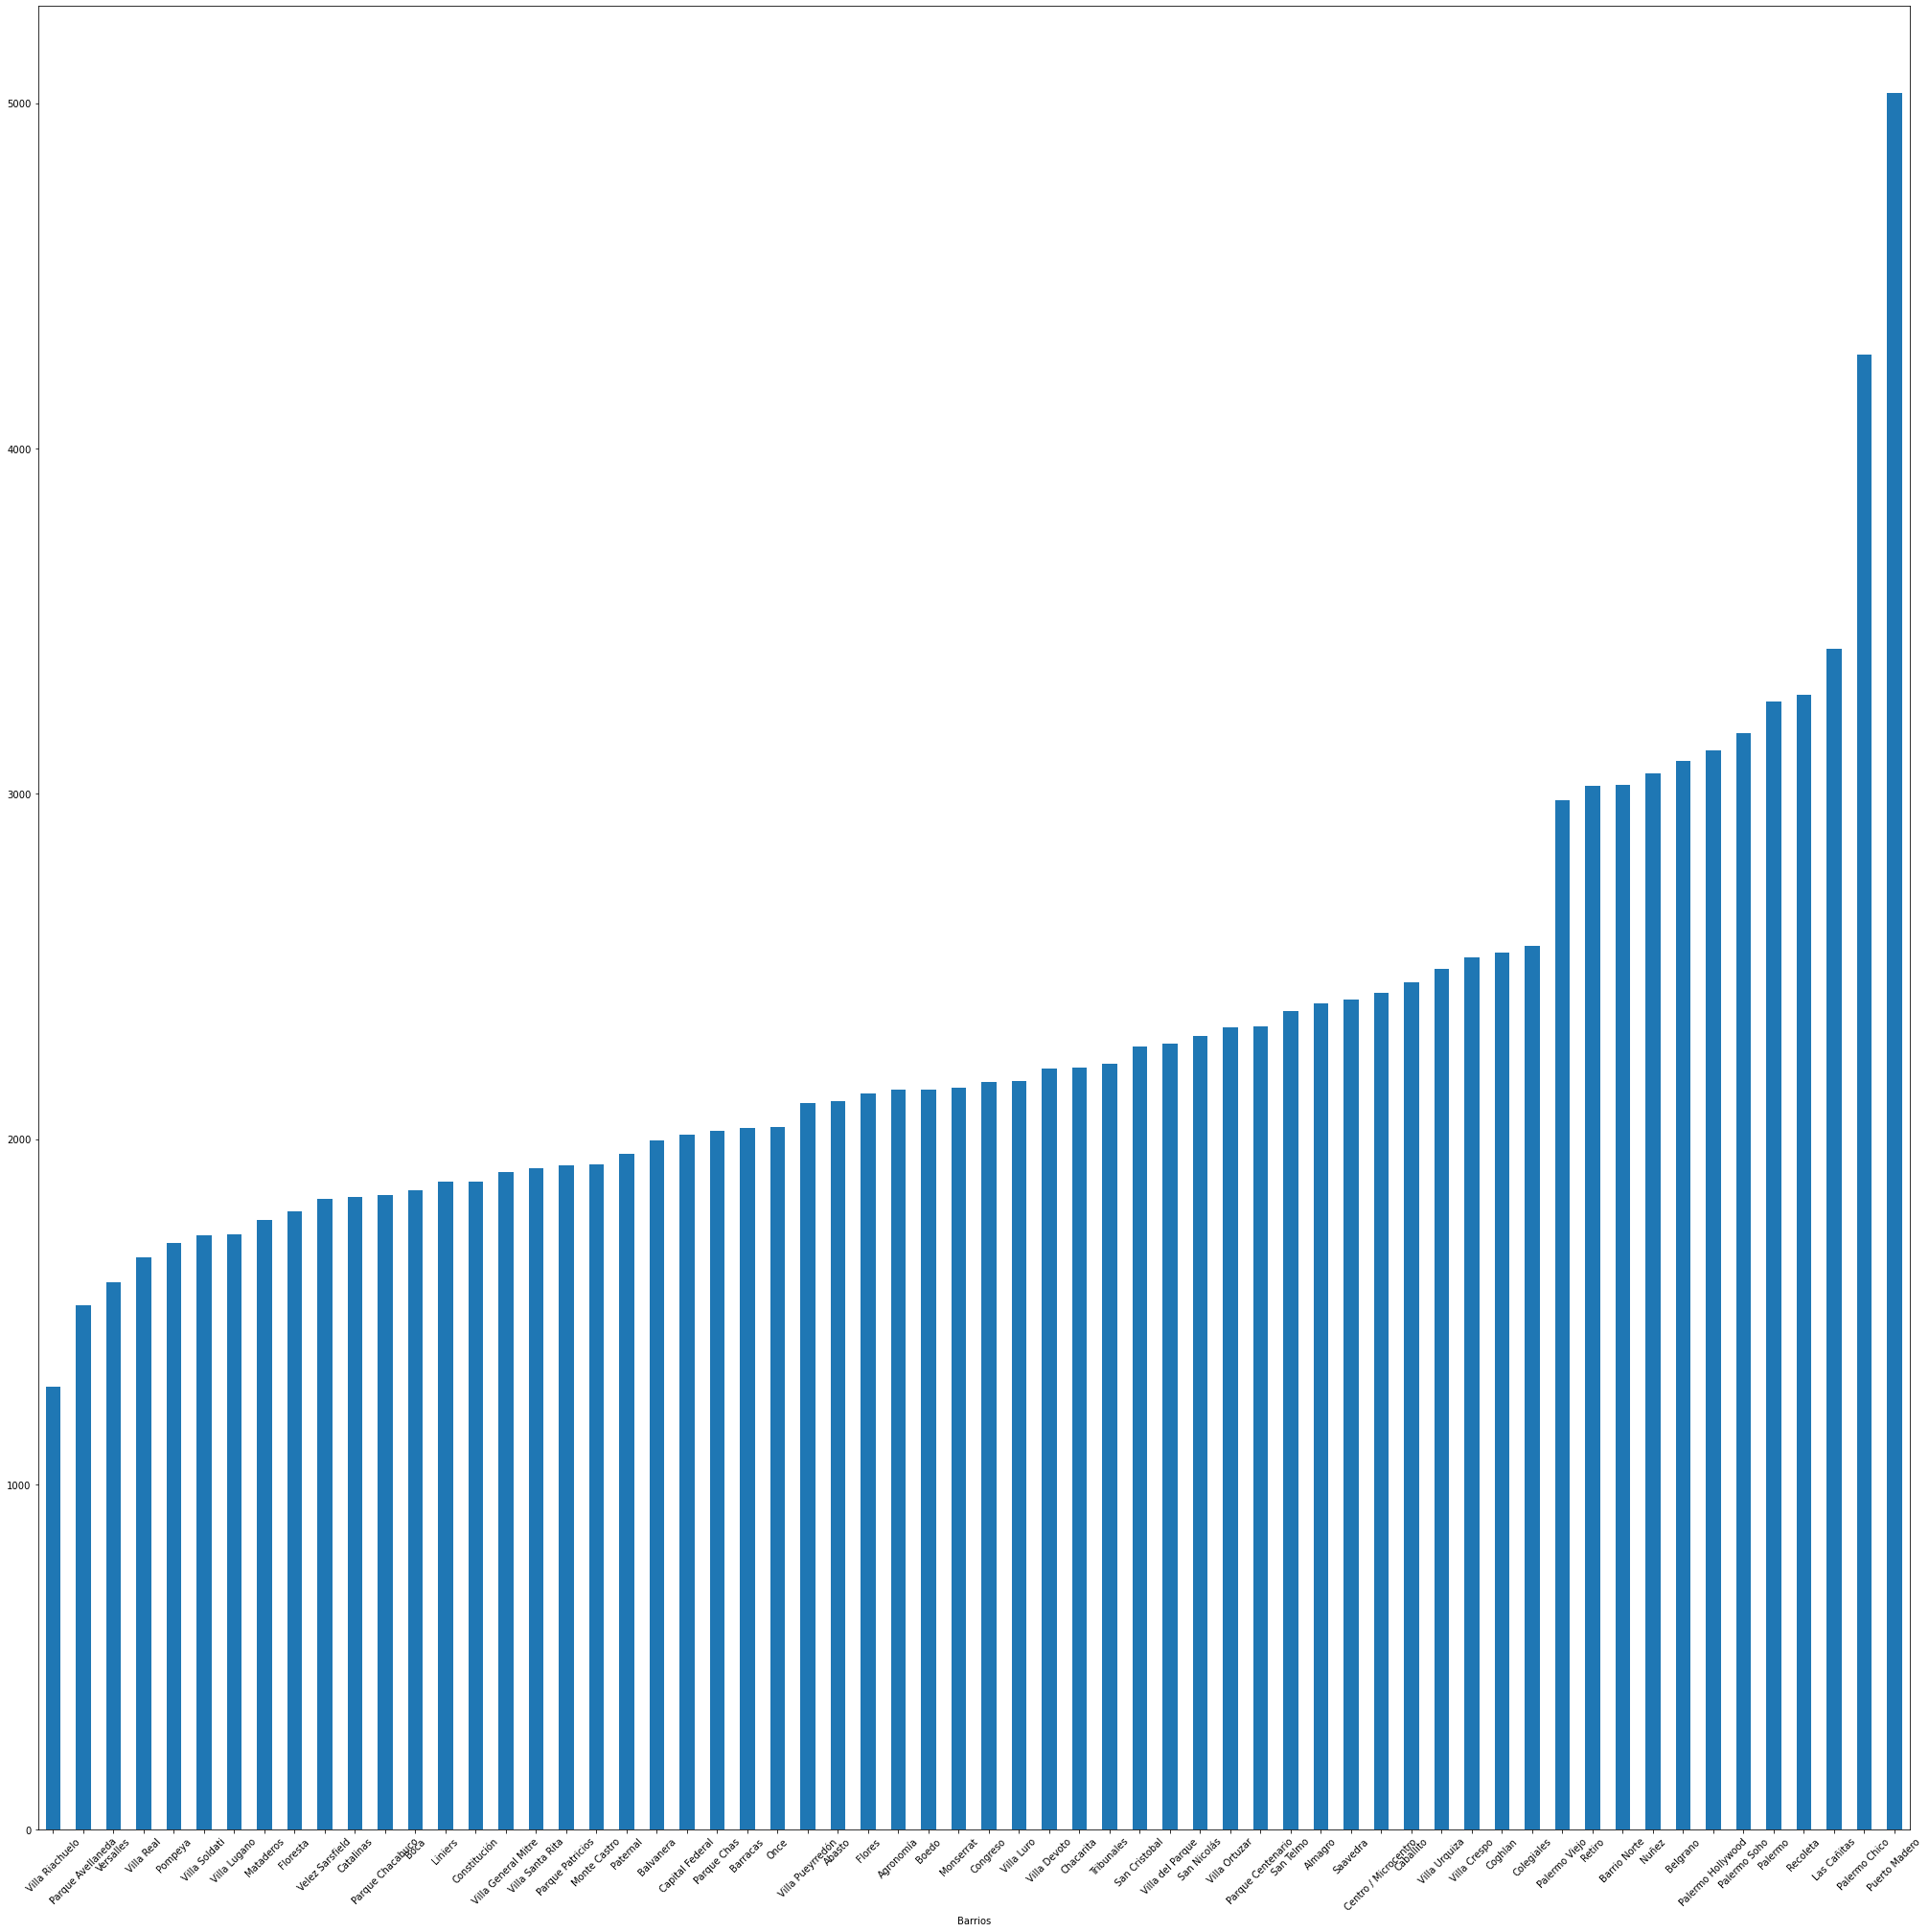

In [13]:
##graficamos el dataframe limpio
serie_x=pd.unique(propiedades_capital2.place_name)
serie_x
serie_y=propiedades_capital2[removed_outliers].groupby('place_name').price_usd_per_m2.mean()
serie_y.sort_values().plot.bar(rot=45,figsize=(35,35), xlabel='Barrios')

In [14]:
#revisamos cuales otras columnas faltan por datos
propiedades_capital2.isna().sum()


Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
price_aprox_usd                3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2                  0
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
properati_url                     0
description                       0
title                             0
image_thumbnail                 488
price_usd_per_m2_mean             0
dtype: int64

In [15]:
#observamos que el campo un campo valioso para determinar el precio es el area de la propiedad
#en este caso no podriamos hacer un promedio, procedemos a removerla surface_covered_in_m2
propiedades_capital3=propiedades_capital2.dropna(axis=0,how='any',subset=['surface_covered_in_m2'])
propiedades_capital3.isna().sum()

Unnamed: 0                        0
operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                    1218
lat-lon                        7896
lat                            7896
lon                            7896
price                          2651
currency                       2651
price_aprox_local_currency     2651
price_aprox_usd                2651
surface_total_in_m2            5093
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                   2653
floor                         27075
rooms                         15120
expenses                      23825
properati_url                     0
description                       0
title                             0
image_thumbnail                 432
price_usd_per_m2_mean             0
dtype: int64

In [16]:
#funcion para extraer del campo description, el numero de ambientes o habitaciones
def limpieza_description(text):
    try:
        txt="(\d+(?=\s+dorm)|\d(?=\s+amb)|\d(?=\s+hab))"
        txt=txt.lower()
        x=int(re.findall(txt, text)[0])
        
    except IndexError:
        x="1"
    return(x) 

In [17]:
#creamos un df nuevo solo con casas y departamentos para poder limpiar la descripcion
propiedades_capital_casas_dptops=propiedades_capital3.loc[(propiedades_capital3.property_type=="apartment")|(propiedades_capital3.property_type=="house")|(propiedades_capital3.property_type=="PH")]

In [18]:
propiedades_capital3.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [19]:
#creamos el patron REGEX para la busqueda de palabras como "dorm","amb" y "hab". Este patron buscará el primer numero 
#que consiga antes de alguna de esas palabras

pricem2USD_fill_values
propiedades_capital3['rooms_fill']=propiedades_capital3['description'].apply(lambda x: limpieza_description(x))

C:\Users\edgar\AppData\Local\Temp/ipykernel_18636/1369611069.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
#propiedades_capital3.columns
propiedades_capital3[['description','rooms','rooms_fill']].sample(5)

,description,rooms,rooms_fill
28536,"Casa en excelente estado, totalmente actualiza...",NaN,3
21201,Departamento de gran categoria en el edificio ...,NaN,1
8453,"Muy linda casa desarrollada en dos plantas, en...",NaN,1
26131,El edificio Serrano 629 cuenta con unidades de...,NaN,3
14848,"Venta de Departamento 3 AMBIENTES en FLORES, C...",NaN,3


In [21]:
#Inputamos los valores Nan de la columna rooms, usando los valores de rooms_fill que obtuvimos de la ultima ejecucion
propiedades_capital3.rooms.fillna(propiedades_capital3.rooms_fill, inplace = True)
propiedades_capital3.dtypes

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                          object
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
price_usd_pe

In [22]:
#Seleccionamos las columnas que nos resultan utiles para un modelo posterior
propiedades_capital_limpio=propiedades_capital3[['property_type','place_name','price','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2',
       'surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','description','price_usd_per_m2_mean']]
propiedades_capital_limpio.rooms=propiedades_capital_limpio.rooms.astype(np.float)

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



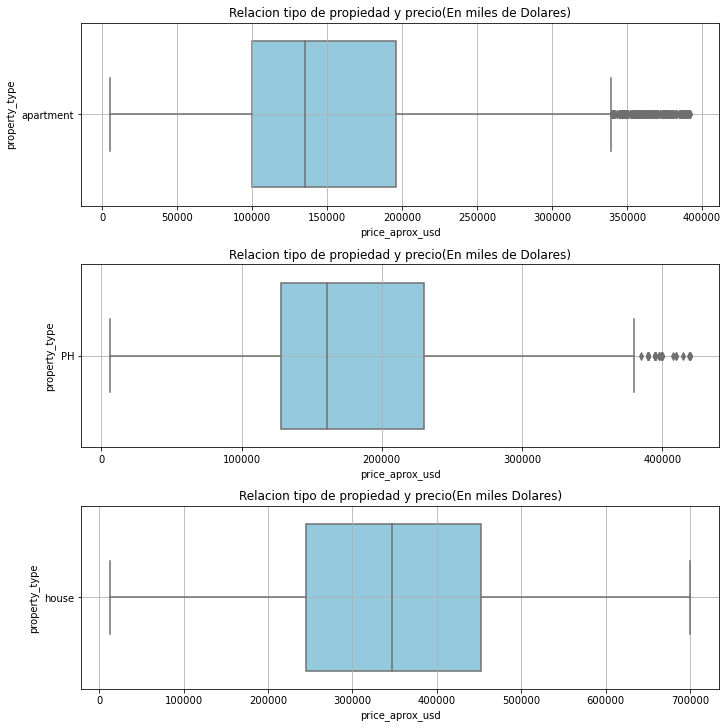

In [23]:
#Utilizamos estos boxplot para analizar la relacion entre los tipos de propiedad y los precios en dolares
propiedades_capital_limpio=propiedades_capital_limpio.dropna(axis=0,how='any',subset=['price_aprox_usd'])
dptos=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="apartment"]
phs=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="PH"]
casas=propiedades_capital_limpio[propiedades_capital_limpio["property_type"]=="house"]
dptos= dptos[(dptos.price <= 392500.0) & (dptos.price >=65000.0) ]
phs=phs[(phs.price <= 428500.0) & (phs.price >=75000.0) ]
casas=casas[(casas.price <= 706000.0) & (casas.price >=110000.0) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax2.set_title("Relacion tipo de propiedad y precio(En miles de Dolares)")
ax3.set_title("Relacion tipo de propiedad y precio(En miles Dolares)")
sns.boxplot(data=dptos,x="price_aprox_usd",y="property_type",ax=ax1, color='skyblue')
sns.boxplot(data=phs,x="price_aprox_usd",y="property_type",ax=ax2, color='skyblue')
sns.boxplot(data=casas,x="price_aprox_usd",y="property_type",ax=ax3, color='skyblue')
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [24]:
#porcentaje de valores nulos por columna
col_null_caba=np.sum(propiedades_capital_limpio.isnull())
col_null_caba.sort_values(ascending=False)
porc_nulos_caba=np.round((col_null_caba/propiedades_capital_limpio.shape[0])*100,2)
porc_nulos_caba.sort_values(ascending=False)


floor                         89.54
surface_total_in_m2           18.32
price_per_m2                   0.01
price_usd_per_m2_mean          0.00
description                    0.00
rooms                          0.00
price_usd_per_m2               0.00
surface_covered_in_m2          0.00
price_aprox_usd                0.00
price_aprox_local_currency     0.00
price                          0.00
place_name                     0.00
property_type                  0.00
dtype: float64

In [25]:
propiedades_capital_surface_limpio=propiedades_capital_limpio
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["price_usd_per_m2"]<100000]
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["surface_total_in_m2"]<10000]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="apartment"]
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="house"]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="PH"]
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio[propiedades_capital_surface_limpio["property_type"]=="store"]

#########################

propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[(propiedades_capital_surface_limpio_casas.surface_total_in_m2 <= 3500) & (propiedades_capital_surface_limpio_casas.surface_total_in_m2 >=30) ]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[(propiedades_capital_surface_limpio_phs.surface_total_in_m2 <= 1000) & (propiedades_capital_surface_limpio_phs.surface_total_in_m2 >=10) ]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[(propiedades_capital_surface_limpio_dptos.surface_total_in_m2 <= 8000) & (propiedades_capital_surface_limpio_dptos.surface_total_in_m2 >=10) ]

#########################

removed_outliers_dptos = propiedades_capital_surface_limpio_dptos.price_usd_per_m2.between(propiedades_capital_surface_limpio_dptos.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_dptos.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[removed_outliers_dptos]

removed_outliers_dptos_area = propiedades_capital_surface_limpio_dptos.surface_total_in_m2.between(propiedades_capital_surface_limpio_dptos.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_dptos.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[removed_outliers_dptos_area]

##########################

removed_outliers_casas = propiedades_capital_surface_limpio_casas.price_usd_per_m2.between(propiedades_capital_surface_limpio_casas.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_casas.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[removed_outliers_casas]

removed_outliers_casas_area = propiedades_capital_surface_limpio_casas.surface_total_in_m2.between(propiedades_capital_surface_limpio_casas.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_casas.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[removed_outliers_casas_area]

###########################

removed_outliers_phs = propiedades_capital_surface_limpio_phs.price_usd_per_m2.between(propiedades_capital_surface_limpio_phs.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_phs.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[removed_outliers_phs]

removed_outliers_phs_area = propiedades_capital_surface_limpio_phs.surface_total_in_m2.between(propiedades_capital_surface_limpio_phs.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_phs.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[removed_outliers_phs_area]


###########################

removed_outliers_stores = propiedades_capital_surface_limpio_stores.price_usd_per_m2.between(propiedades_capital_surface_limpio_stores.price_usd_per_m2.quantile(.05), propiedades_capital_surface_limpio_stores.price_usd_per_m2.quantile(.95))
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio_phs[removed_outliers_phs]

removed_outliers_stores_area = propiedades_capital_surface_limpio_stores.surface_total_in_m2.between(propiedades_capital_surface_limpio_stores.surface_total_in_m2.quantile(.05), propiedades_capital_surface_limpio_stores.surface_total_in_m2.quantile(.95))
propiedades_capital_surface_limpio_stores=propiedades_capital_surface_limpio_stores[removed_outliers_stores_area]

###########################

propiedades_capital_surface_covered_fill=propiedades_capital_limpio.groupby('place_name').surface_covered_in_m2.mean()
propiedades_capital_limpio_surface_total_fill=propiedades_capital_limpio.groupby('place_name').surface_total_in_m2.mean()
propiedades_capital_surface=propiedades_capital_limpio_surface_total_fill/propiedades_capital_surface_covered_fill
propiedades_capital_surface_fill_pd=pd.DataFrame(propiedades_capital_surface)
propiedades_capital_surface_fill_pd.reset_index(inplace=True)
propiedades_capital_surface_fill_pd.columns=['place_name','surface_mean']
propiedades_capital_surface_limpio=propiedades_capital_limpio.merge(propiedades_capital_surface_fill_pd, on='place_name', how='left',suffixes = ("", "_mean"))

############################



C:\Users\edgar\AppData\Local\Temp/ipykernel_18636/1425289111.py:43: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [26]:
lista_barrios= propiedades_capital_surface_limpio.place_name.unique()

In [27]:
#Importamos librerias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
#################################


for i in lista_barrios:
    
    globals()['dptos_barrio%s' % i]=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["place_name"]==i]


In [28]:
#propiedades_capital_surface_limpio_casas.surface_total_in_m2[removed_outliers_casas].describe()
propiedades_capital_surface_limpio_dptos[removed_outliers_dptos].price_usd_per_m2.describe()

C:\Users\edgar\AppData\Local\Temp/ipykernel_18636/4258729379.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



count    15479.000000
mean      2707.594979
std        833.990935
min       1500.000000
25%       2142.857143
50%       2538.461538
75%       3018.867925
max       6318.681319
Name: price_usd_per_m2, dtype: float64

In [29]:
diferencia_surface_ph=propiedades_capital_surface_limpio_phs.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_phs.surface_covered_in_m2.mean()
diferencia_surface_casas=propiedades_capital_surface_limpio_casas.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_casas.surface_covered_in_m2.mean()
diferencia_surface_dptos=propiedades_capital_surface_limpio_dptos.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_dptos.surface_covered_in_m2.mean()
diferencia_surface_stores=propiedades_capital_surface_limpio_stores.surface_total_in_m2.mean() / propiedades_capital_surface_limpio_stores.surface_covered_in_m2.mean()

print("Porcentaje de diferencia para PH: "+str(np.around(diferencia_surface_ph,decimals=2)) + "%")
print("Porcentaje de diferencia para Dptos: "+str(np.around(diferencia_surface_dptos, decimals=2)) + "%")
print("Porcentaje de diferencia para Casas: "+str(np.around(diferencia_surface_casas, decimals=2)) + "%")
print("Porcentaje de diferencia para Tiendas: "+str(np.around(diferencia_surface_stores, decimals=2)) + "%")

Porcentaje de diferencia para PH: 1.32%
Porcentaje de diferencia para Dptos: 1.12%
Porcentaje de diferencia para Casas: 1.57%
Porcentaje de diferencia para Tiendas: 1.3%


In [30]:
propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.loc[(propiedades_capital_surface_limpio.property_type=="apartment")|(propiedades_capital_surface_limpio.property_type=="house")|(propiedades_capital_surface_limpio.property_type=="PH")|(propiedades_capital_surface_limpio.property_type=="store")]

#propiedades_capital_surface_limpio_post=propiedades_capital_surface_limpio_post.apply(lambda x: x['surface_covered_in_m2']*diferencia_surface_ph if x['property_type']=='PH' and pd.isna(x['surface_total_in_m2']) else x,axis=1)
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' & propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = diferencia_surface_ph * surface_total_in_m2
#propiedades_capital_surface_limpio_post.loc[propiedades_capital_surface_limpio_post['property_type'] == 'PH' && propiedades_capital_surface_limpio_post['surface_total_in_m2'].isnull(), 'surface_total_in_m2'] = propiedades_capital_surface_limpio_post['diferencia_surface_ph'] * propiedades_capital_surface_limpio_post['surface_total_in_m2']
def diferencia(x):
    #total=x['surface_total_in_m2']
    total=np.around(x['surface_total_in_m2'], decimals=1)
    if x['property_type'] == 'PH' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_ph
        return(total)
    elif x['property_type'] == 'apartment' and pd.isna(x['surface_total_in_m2']):
        total = int(x['surface_covered_in_m2']) * diferencia_surface_dptos
        return(total)
    elif x['property_type'] == 'store' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_stores
        return(total)
    elif x['property_type'] == 'house' and pd.isna(x['surface_total_in_m2']):
        total = x['surface_covered_in_m2'] * diferencia_surface_casas
        return(total)
    else:
        return(total)
propiedades_capital_surface_limpio["_new_surface_total"]=propiedades_capital_surface_limpio.apply(lambda x: diferencia(x), axis=1) 

In [31]:
propiedades_capital_surface_limpio.rename(columns={'0': 'surface_mean'})
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean', '_new_surface_total'],
      dtype='object')

In [32]:
surface_total_in_m2 = propiedades_capital_limpio['surface_total_in_m2'].mean()
surface_total_in_m2
surface_covered_in_m2 = propiedades_capital_limpio['surface_covered_in_m2'].mean()
surface_covered_in_m2 
surface_covered_in_m2 * 100 / surface_total_in_m2

88.26944144005208

In [33]:
(int(propiedades_capital_surface_limpio_dptos[['price_usd_per_m2']].mean())+int(propiedades_capital_surface_limpio_dptos[['price_usd_per_m2']].std())*2)

4373

In [34]:
#propiedades_capital_surface_limpio_casas.surface_total_in_m2[removed_outliers_casas].describe()
propiedades_capital_surface_limpio_dptos[removed_outliers_dptos].price_usd_per_m2.describe()

C:\Users\edgar\AppData\Local\Temp/ipykernel_18636/4258729379.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



count    15479.000000
mean      2707.594979
std        833.990935
min       1500.000000
25%       2142.857143
50%       2538.461538
75%       3018.867925
max       6318.681319
Name: price_usd_per_m2, dtype: float64

In [35]:
propiedades_capital_surface_limpio_casas=propiedades_capital_surface_limpio_casas[(propiedades_capital_surface_limpio_casas.surface_total_in_m2 <= 3500) & (propiedades_capital_surface_limpio_casas.surface_total_in_m2 >=30) ]
propiedades_capital_surface_limpio_phs=propiedades_capital_surface_limpio_phs[(propiedades_capital_surface_limpio_phs.surface_total_in_m2 <= 1000) & (propiedades_capital_surface_limpio_phs.surface_total_in_m2 >=10) ]
propiedades_capital_surface_limpio_dptos=propiedades_capital_surface_limpio_dptos[(propiedades_capital_surface_limpio_dptos.surface_total_in_m2 <= 8000) & (propiedades_capital_surface_limpio_dptos.surface_total_in_m2 >=10) ]

In [36]:
print("Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: ")
print(propiedades_capital_surface_limpio.surface_total_in_m2.describe())
print("")
print("Hay "+str(propiedades_capital_surface_limpio.surface_total_in_m2.isna().sum())+ " valores NaN para surface_covered_in_m2")

Un describe al dataset ANTES de aplicar la multiplicacion por el procentaje de diferencia: 
count    22319.000000
mean       111.486626
std        212.760083
min         10.000000
25%         42.000000
50%         62.000000
75%        111.000000
max      10958.000000
Name: surface_total_in_m2, dtype: float64

Hay 5007 valores NaN para surface_covered_in_m2


In [37]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
16126,store,Villa Soldati,10958.0,10958.0
2146,house,Capital Federal,7832.0,4111.0
15954,store,Boca,7722.0,7722.0
19994,store,San Telmo,5079.0,5079.0
15863,store,Villa Luro,4800.0,4800.0
16123,store,Capital Federal,4800.0,4800.0
15906,store,Parque Patricios,4590.0,4590.0
22689,store,San Telmo,4300.0,3800.0
16010,store,Parque Patricios,4229.0,4229.0
16017,store,San Telmo,3800.0,3800.0


In [38]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [39]:
propiedades_capital_surface_limpio[["_new_surface_total",'property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,_new_surface_total,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
19512,41.000000,apartment,Caballito,41.0,36.0
16061,45.000000,apartment,Saavedra,45.0,54.0
21972,96.000000,apartment,Villa Crespo,96.0,78.0
11962,343.000000,apartment,Barrio Norte,343.0,323.0
20467,80.000000,apartment,Parque Patricios,80.0,67.0
24016,113.000000,apartment,Belgrano,113.0,101.0
18896,71.000000,apartment,Palermo,71.0,67.0
1393,31.000000,apartment,Villa Devoto,31.0,31.0
3777,62.918069,apartment,Boca,NaN,56.0
25062,73.029901,apartment,San Cristobal,NaN,65.0


In [40]:
#Inputamos los valores NaN en superficie total con los valores nuevos del apply y la funcion
propiedades_capital_surface_limpio.surface_total_in_m2.fillna(propiedades_capital_surface_limpio._new_surface_total, inplace = True)

In [41]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10,'surface_total_in_m2')

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
18070,apartment,Barrio Norte,210101.407740,187000.0
13548,house,Liniers,12850.975566,8175.0
16126,store,Villa Soldati,10958.000000,10958.0
13471,apartment,Monte Castro,10282.610073,9152.0
15643,apartment,Palermo,7897.341150,7029.0
2146,house,Capital Federal,7832.000000,4111.0
15954,store,Boca,7722.000000,7722.0
24468,apartment,Floresta,7341.190365,6534.0
25806,apartment,Flores,6810.880929,6062.0
977,apartment,Caballito,6010.922628,5350.0


In [42]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].sample(10)

,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
4936,apartment,Puerto Madero,132.000000,125.0
4998,apartment,Belgrano,40.000000,40.0
9485,apartment,Capital Federal,80.000000,116.0
1201,apartment,Centro / Microcentro,48.000000,38.0
11136,store,Pompeya,26.049325,20.0
22299,apartment,Retiro,180.000000,180.0
11673,house,Caballito,31.439696,20.0
14341,PH,Coghlan,84.000000,84.0
7531,apartment,Villa del Parque,73.029901,65.0
8557,apartment,Flores,53.000000,50.0


In [43]:
print("Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: ")
propiedades_capital_surface_limpio.surface_total_in_m2.describe()

Un describe al dataset DESPUES de aplicar la multiplicacion por el procentaje de diferencia: 


count     27326.000000
mean        121.727397
std        1294.905059
min           1.123537
25%          42.000000
50%          63.000000
75%         112.000000
max      210101.407740
Name: surface_total_in_m2, dtype: float64

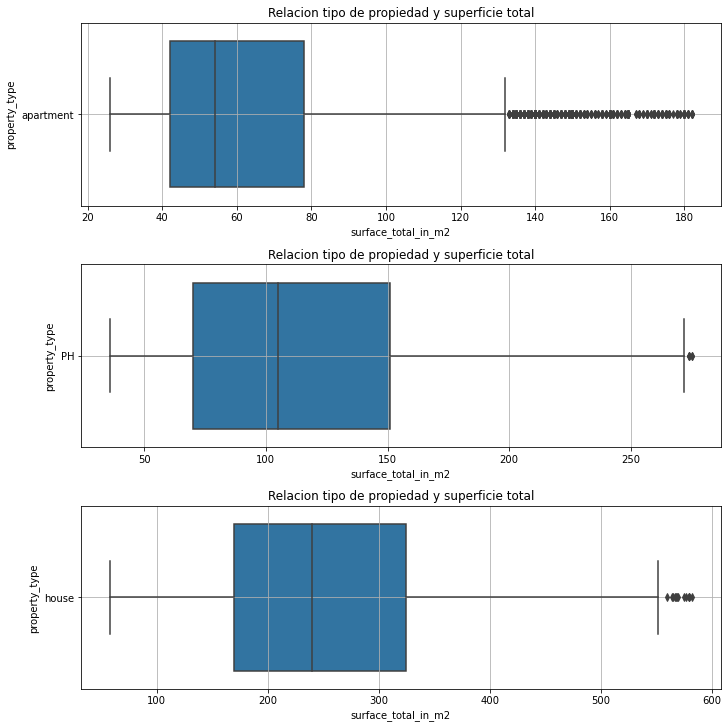

In [44]:
dptos= dptos[(dptos.surface_total_in_m2 <= 182.91) & (dptos.surface_total_in_m2 >=26.0) ]
phs=phs[(phs.surface_total_in_m2 <= 275.0) & (phs.surface_total_in_m2 >=35.0) ]
casas=casas[(casas.surface_total_in_m2 <= 583.12) & (casas.surface_total_in_m2 >=56.81) ]
figure,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(10,10))
ax1.set_title("Relacion tipo de propiedad y superficie total")
ax2.set_title("Relacion tipo de propiedad y superficie total")
ax3.set_title("Relacion tipo de propiedad y superficie total")
sns.boxplot(data=dptos,x="surface_total_in_m2",y="property_type",ax=ax1)
sns.boxplot(data=phs,x="surface_total_in_m2",y="property_type",ax=ax2)
sns.boxplot(data=casas,x="surface_total_in_m2",y="property_type",ax=ax3)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

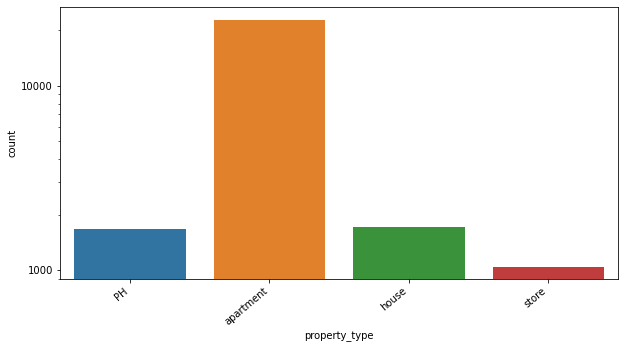

In [45]:
plt.figure(figsize=(10,5))
from matplotlib.ticker import ScalarFormatter

plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = propiedades_capital_surface_limpio, x = "property_type")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")


plt.show()

<AxesSubplot:>

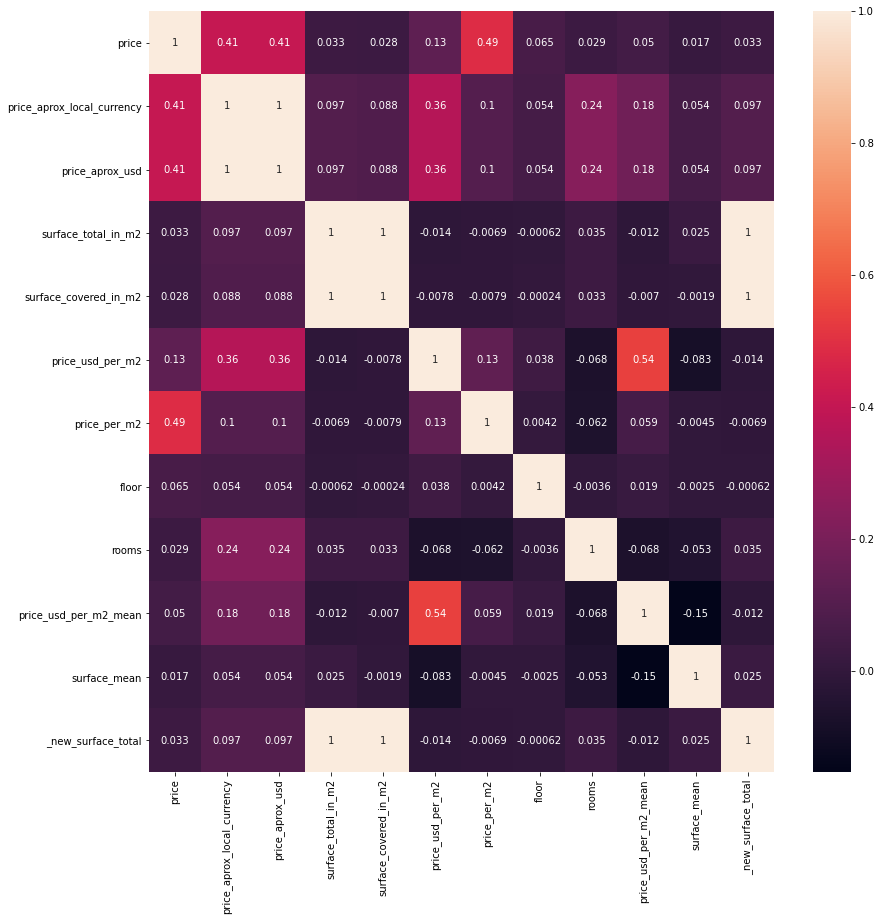

In [46]:
#Realizamos un heatmap para observar el grado de correlacion entre las variables
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('surface_mean',axis=1)
#propiedades_capital_surface_limpio=propiedades_capital_surface_limpio.drop('price_usd_per_m2_mean', axis=1)
fig =plt.subplots(figsize=(14,14))
sns.heatmap(propiedades_capital_surface_limpio.corr(), annot=True)

In [47]:
propiedades_capital_surface_limpio.dtypes


property_type                  object
place_name                     object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
description                    object
price_usd_per_m2_mean         float64
surface_mean                  float64
_new_surface_total            float64
dtype: object

In [48]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2               0
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
_new_surface_total                0
dtype: int64

In [49]:
propiedades_capital_surface_limpio.isna().sum()

property_type                     0
place_name                        0
price                             0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2               0
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      2
floor                         24467
rooms                             0
description                       0
price_usd_per_m2_mean             0
surface_mean                      0
_new_surface_total                0
dtype: int64

In [50]:
dptos=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["property_type"]=="apartment"]
casas=propiedades_capital_surface_limpio_casas[propiedades_capital_surface_limpio_casas["property_type"]=="house"]
phs=propiedades_capital_surface_limpio_phs[propiedades_capital_surface_limpio_phs["property_type"]=="PH"]
stores=propiedades_capital_surface_limpio_stores[propiedades_capital_surface_limpio_stores["property_type"]=="store"]


In [51]:
from sklearn import *
X = phs[['price','price_usd_per_m2', 'rooms', 'surface_total_in_m2','surface_covered_in_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = phs['price_aprox_usd']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print(model_fit_ridge_cv.alpha_)

print(model_fit_ridge_cv.best_score_)

0.3
0.9999965618886602


In [53]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

[7.93181948e+04 2.76589972e+02 1.34257203e+00 4.47006098e+02
 3.73253561e+01]
181999.72035830235
0.999997412329074


In [54]:
model_fit_ridge.score(X_test, y_test)

0.9999974685639783

In [55]:
propiedades_capital_surface_limpio.property_type.value_counts()

apartment    22880
house         1722
PH            1676
store         1048
Name: property_type, dtype: int64

In [56]:
propiedades_capital_surface_limpio.columns

Index(['property_type', 'place_name', 'price', 'price_aprox_local_currency',
       'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'description',
       'price_usd_per_m2_mean', 'surface_mean', '_new_surface_total'],
      dtype='object')

In [57]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
18070,apartment,Barrio Norte,210101.407740
13548,house,Liniers,12850.975566
16126,store,Villa Soldati,10958.000000
13471,apartment,Monte Castro,10282.610073
15643,apartment,Palermo,7897.341150


In [58]:
propiedades_capital_surface_limpio[['property_type','place_name','surface_total_in_m2']].nlargest(5, columns='surface_total_in_m2')

,property_type,place_name,surface_total_in_m2
18070,apartment,Barrio Norte,210101.407740
13548,house,Liniers,12850.975566
16126,store,Villa Soldati,10958.000000
13471,apartment,Monte Castro,10282.610073
15643,apartment,Palermo,7897.341150


In [59]:
dptos[['price_usd_per_m2','property_type','place_name','surface_total_in_m2','surface_covered_in_m2']].nlargest(10, columns='price_usd_per_m2')

,price_usd_per_m2,property_type,place_name,surface_total_in_m2,surface_covered_in_m2
22044,6318.681319,apartment,Palermo,91.0,87.0
19757,6316.153846,apartment,Capital Federal,156.0,146.0
19793,6313.500000,apartment,Capital Federal,140.0,121.0
932,6307.692308,apartment,Palermo,52.0,52.0
10468,6304.347826,apartment,Palermo,92.0,89.0
25732,6304.347826,apartment,Puerto Madero,115.0,82.0
24587,6296.296296,apartment,Puerto Madero,135.0,130.0
5242,6285.714286,apartment,Belgrano,175.0,165.0
4640,6279.069767,apartment,Puerto Madero,86.0,86.0
12183,6255.319149,apartment,Puerto Madero,188.0,188.0


In [60]:
stores[['price_usd_per_m2']].describe()

,price_usd_per_m2
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [61]:
int(dptos[['price_usd_per_m2']].mean())

2707

In [62]:
(int(dptos[['price_usd_per_m2']].mean())+int(dptos[['price_usd_per_m2']].std())*2)

4373

# Scikit-Learn Metodología de trabajo

1) Seleccionar el modelo: Linear Regresion

In [63]:
#Importamos librerias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model

2) Elegir los hiperparámetros Dejo los default

3) Presentar los datos en una matriz de features y un vestot traget

In [66]:
df_clean=propiedades_capital_surface_limpio[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=propiedades_capital_surface_limpio_dptos[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=propiedades_capital_surface_limpio_casas[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
#df_clean=propiedades_capital_surface_limpio_phs[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]


In [67]:
X=df_clean.drop(['price_usd_per_m2'], axis=1)
#X=df_clean2['price']
Y=df_clean['price_usd_per_m2']

In [68]:
#instanciamos el modelo
lm = linear_model.LinearRegression()

4) Separamos set de entrenamiento y testing

In [69]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)

5) Ajustamos el modelo a los datos de entrenamiento

In [70]:
model_lr=lm.fit(X,Y)

6) Predecimos etiquetas para datos desconocidos

In [71]:
y_pred=lm.predict(X_test_2)

7) Evaluamos performance del modelo

In [72]:
#no me funcionó
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test_2,y_pred)

In [73]:
#score del modelo de entrenamiento
model_lr.score(X_train_2,y_train_2)

0.17343482628936102

Probamos con U$S/m2 vs Precio

In [74]:
X_2=df_clean[['price_aprox_usd']]
Y_2=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_2 = linear_model.LinearRegression()

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_2,Y_2, random_state=1)

model_lr_2=lm_2.fit(X_2,Y_2)

y_pred_2=lm_2.predict(X_test_3)

model_lr_2.score(X_train_3,y_train_3)

0.13306520783953424

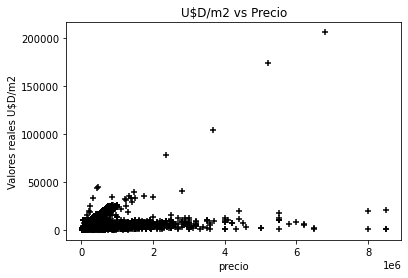

In [75]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_2, Y_2, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_2, Y_2)
plt.xlabel("precio")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs Precio')
plt.show()

# Graficamos el modelo
#plt.plot(Y_2,Y_2, '-.',c='grey')
#plt.scatter(y_pred_2, Y_2, s=30, c='r', marker='+', zorder=10)
#plt.xlabel("Predicciones de U$S/m2 usando RL")
#plt.ylabel("Valores reales U$S")
#plt.title('Comparación entre el modelo y los valores reales')
#plt.show()

Pruebo con precio/m2 vs surface_total

In [76]:
X_3=df_clean[['surface_total_in_m2']]
Y_3=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_3 = linear_model.LinearRegression()

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_3,Y_3, random_state=1)

model_lr_3=lm_3.fit(X_3,Y_3)

y_pred_3=lm_3.predict(X_test_4)

model_lr_3.score(X_train_4,y_train_4)

9.733092490105122e-05

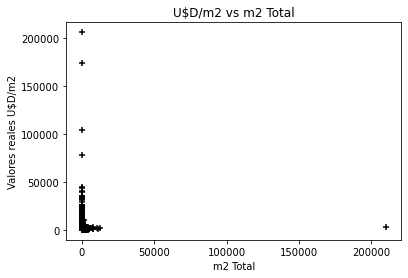

In [77]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_3, Y_3, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_3, Y_3)
plt.xlabel("m2 Total")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs m2 Total')
plt.show()

Pruebo con precio/m2 vs surface_covered

In [78]:
X_4=df_clean[['surface_covered_in_m2']]
Y_4=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_4 = linear_model.LinearRegression()

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_4,Y_4, random_state=1)

model_lr_4=lm_4.fit(X_4,Y_4)

y_pred_4=lm_4.predict(X_test_5)

model_lr_4.score(X_train_5,y_train_5)

8.007842328239256e-06

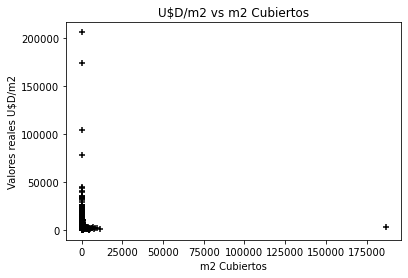

In [79]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_4, Y_4, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_4, Y_4)
plt.xlabel("m2 Cubiertos")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs m2 Cubiertos')
plt.show()

Pruebo con precio/m2 vs room

In [80]:
X_5=df_clean[['rooms']]
Y_5=df_clean[['price_usd_per_m2']]

#instanciamos el modelo
lm_5 = linear_model.LinearRegression()

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_5,Y_5, random_state=1)

model_lr_5=lm_5.fit(X_5,Y_5)

y_pred_5=lm_5.predict(X_test_6)

model_lr_5.score(X_train_6,y_train_6)

0.004595362256266777

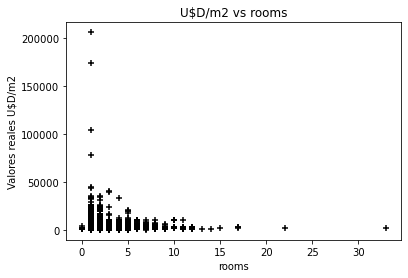

In [81]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_5, Y_5, s=30, c='black', marker='+', zorder=10)
#plt.scatter(X_4, Y_4)
plt.xlabel("rooms")
plt.ylabel("Valores reales U$D/m2")
plt.title('U$D/m2 vs rooms')
plt.show()

In [82]:
stores[['price_usd_per_m2']].describe()

,price_usd_per_m2
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [89]:
from scipy import stats
import statsmodels.api as sm
for i in lista_barrios:
    
    globals()['dptos_barrio%s' % i]=propiedades_capital_surface_limpio_dptos[propiedades_capital_surface_limpio_dptos["place_name"]==i]
    
    df_clean=globals()['dptos_barrio%s' % i]
    df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    X=df_clean.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_clean['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    #price_usd_place_rooms = df_clean["price_usd_per_m2"][df_clean["rooms"]==1]
    #price_usd_price= df_clean["price_usd_per_m2"][df_clean["price_aprox_usd"]==]
    #HamDEnfermedad3 = datos["Ham-D"][datos["Enfermedad"]
    #print("El valor de P-test: "+str(stats.ttest_rel(price_usd_place_rooms, price_usd_price)))
    
    print("Para departamentos en el barrio " + str(i) + " el R2 es: "+str(model_lr.score(X_train_2,y_train_2)))
    print(est2.summary())
    print("")

Para departamentos en el barrio Mataderos el R2 es: 0.9192348758104002
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     132.1
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           9.60e-31
Time:                        14:58:45   Log-Likelihood:                -449.91
No. Observations:                  71   AIC:                             909.8
Df Residuals:                      66   BIC:                             921.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     592.6
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           5.47e-78
Time:                        14:58:45   Log-Likelihood:                -811.06
No. Observations:                 125   AIC:                             1632.
Df Residuals:                     120   BIC:                             1646.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2068.82

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     728.1
Date:                Fri, 08 Oct 2021   Prob (F-statistic):          8.63e-231
Time:                        14:58:45   Log-Likelihood:                -4103.5
No. Observations:                 616   AIC:                             8217.
Df Residuals:                     611   BIC:                             8239.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2242.99

Para departamentos en el barrio Congreso el R2 es: 0.8219750845480183
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     150.4
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           9.06e-46
Time:                        14:58:45   Log-Likelihood:                -823.43
No. Observations:                 125   AIC:                             1657.
Df Residuals:                     120   BIC:                             1671.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Para departamentos en el barrio Saavedra el R2 es: 0.8330628342239088
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     363.1
Date:                Fri, 08 Oct 2021   Prob (F-statistic):          5.71e-117
Time:                        14:58:45   Log-Likelihood:                -2166.1
No. Observations:                 322   AIC:                             4342.
Df Residuals:                     317   BIC:                             4361.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest onl

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     158.1
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           1.76e-11
Time:                        14:58:46   Log-Likelihood:                -94.759
No. Observations:                  19   AIC:                             199.5
Df Residuals:                      14   BIC:                             204.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2379.06

Para departamentos en el barrio Boca el R2 es: 0.9198349014533442
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     262.4
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           4.32e-51
Time:                        14:58:46   Log-Likelihood:                -570.30
No. Observations:                 102   AIC:                             1151.
Df Residuals:                      97   BIC:                             1164.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9



Para departamentos en el barrio Monte Castro el R2 es: 0.9845975463075419
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     457.5
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           7.82e-18
Time:                        14:58:46   Log-Likelihood:                -119.79
No. Observations:                  23   AIC:                             249.6
Df Residuals:                      18   BIC:                             255.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

Para departamentos en el barrio Villa Santa Rita el R2 es: 0.9475870719290032
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     27.20
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           0.000104
Time:                        14:58:46   Log-Likelihood:                -70.234
No. Observations:                  13   AIC:                             150.5
Df Residuals:                       8   BIC:                             153.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=13



                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     53.04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           6.50e-14
Time:                        14:58:46   Log-Likelihood:                -267.65
No. Observations:                  38   AIC:                             545.3
Df Residuals:                      33   BIC:                             553.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1914.13

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [97]:
for i in lista_barrios:
    
    globals()['casas_barrio%s' % i]=propiedades_capital_surface_limpio_casas[propiedades_capital_surface_limpio_casas["place_name"]==i]
    df_clean=globals()['casas_barrio%s' % i]
    df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2']]
    X=df_clean.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_clean['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    #price_usd_place_rooms = df_clean["price_usd_per_m2"][df_clean["rooms"]==1]
    #price_usd_price= df_clean["price_usd_per_m2"][df_clean["price_aprox_usd"]==]
    #HamDEnfermedad3 = datos["Ham-D"][datos["Enfermedad"]
    #print("El valor de P-test: "+str(stats.ttest_rel(price_usd_place_rooms, price_usd_price)))
    
    print("Para casas en el barrio " + str(i) + " el R2 es: "+str(model_lr.score(X_train_2,y_train_2)))
    print(est2.summary())
    print("")

Para casas en el barrio Mataderos el R2 es: 0.8651302296828682
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     119.8
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           1.57e-25
Time:                        15:07:12   Log-Likelihood:                -420.21
No. Observations:                  65   AIC:                             848.4
Df Residuals:                      61   BIC:                             857.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18



ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [91]:
for i in lista_barrios:
    
    globals()['phs_barrio%s' % i]=propiedades_capital_surface_limpio_phs[propiedades_capital_surface_limpio_phs["place_name"]==i]
    df_clean=globals()['phs_barrio%s' % i]
    df_clean=df_clean[['price_usd_per_m2','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','rooms']]
    X=df_clean.drop(['price_usd_per_m2'], axis=1)
    #X=df_clean2['price']
    Y=df_clean['price_usd_per_m2']
    lm = linear_model.LinearRegression()
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,Y, random_state=1)
    model_lr=lm.fit(X,Y)
    y_pred=lm.predict(X_test_2)
    
    
    X2= sm.add_constant(X)
    est= sm.OLS(Y, X2)
    est2= est.fit()
    
    print("Para phs en el barrio " + str(i) + " el R2 es: "+str(model_lr.score(X_train_2,y_train_2)))
    print(est2.summary())
    print("")

Para phs en el barrio Mataderos el R2 es: 0.9084938972047075
                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     124.5
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           2.40e-25
Time:                        15:02:44   Log-Likelihood:                -344.67
No. Observations:                  55   AIC:                             699.3
Df Residuals:                      50   BIC:                             709.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\edgar\Anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning:

divide by zero encountered in double_scalars



ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [96]:
phs.shape

(979, 13)